In [1]:
import os, math
from collections import defaultdict, namedtuple, deque
import dataclasses
from dataclasses import dataclass
import itertools
from enum import StrEnum, auto
import sqlite3
import logging
import logging.handlers
import pickle
import datetime
import multiprocessing as mp

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_4096'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()
    
print(f'xp = {xp.__name__}')

def get_full_db_file_name(db_file_name):
    return os.path.join(config.dataset_path, config.db_file_name_prefix + db_file_name)

train_db_con = sqlite3.connect(get_full_db_file_name(config.train_db_file_name))
test_db_con = sqlite3.connect(get_full_db_file_name(config.test_db_file_name))

mp_ctx = mp.get_context('spawn') # req-d for CUPY to work, fork method leads to failures in bootstrap somewhere around CUDA

xp = numpy


In [3]:
%run sequencing_sp.ipynb

In [4]:
DF_TEST_RESULTS = pd.DataFrame(columns=['test_run_id', 'config_variant', 'cortical_columns', 'train_images_count', 'train_runs',
                                        'source_ds', 'test_image_id', 'true_value', 'infer_value', 'match_tab_index', 'match_score'])
TRAIN_RUN_ID = 0
TEST_RUN_ID = 0

In [5]:
hdc = Hdc(10_000, xp)

In [6]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 28 μs, sys: 0 ns, total: 28 μs
Wall time: 37.9 μs


((1000, 5), (200, 5))


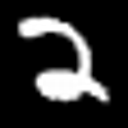
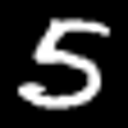
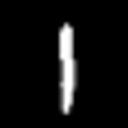
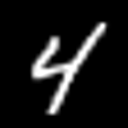
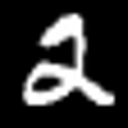
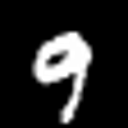
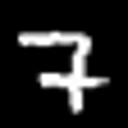
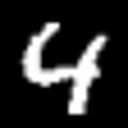
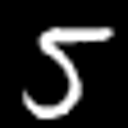
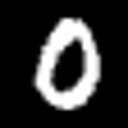
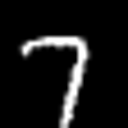
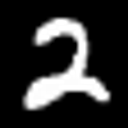
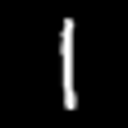
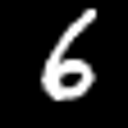
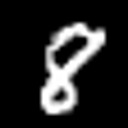
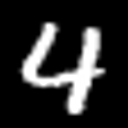

In [7]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [8]:
COS_SIM_45 = np.sqrt(2) / 2
COS_SIM_30 = np.sqrt(3) / 2

In [9]:
HOOK_HISTORY_LEN = 5
HOOK_LV_LEN = (1 + HOOK_HISTORY_LEN) * 4

In [27]:
def _calc_connection_vector(si_ind_from, si_ind_to, sensor_instance_ind_dict):
    si_from = sensor_instance_ind_dict[si_ind_from]
    si_to = sensor_instance_ind_dict[si_ind_to]
    return np.array([si_to.x - si_from.x, si_to.y - si_from.y])

def _calc_normal_vector(si_ind, sensor_instance_ind_dict):
    si = sensor_instance_ind_dict[si_ind]
    return np.array([si.normal_vec.real, si.normal_vec.imag])

# connection vector is ingress by nature, i.e. it describes vector which _ENTERS_ given si_ind during CW tracing
def calc_si_connection_vectors(sequences, sensor_instance_ind_dict):
    connection_vectors_list = []
    
    for seq in sequences:
        seq_pairs = zip(seq[-1:] + seq[:-1], seq)
        cv = list(map(lambda si_inds: _calc_connection_vector(si_inds[0], si_inds[1], sensor_instance_ind_dict), seq_pairs))
        cv = np.array(cv)
        connection_vectors_list.append(cv)

    return connection_vectors_list

def calc_si_latent_vectors(sequences, sensor_instance_ind_dict):
    sensor_instance_ind_to_latent_vector = {}
    
    for seq in sequences:
        normal_vectors = list(map(lambda si_ind: _calc_normal_vector(si_ind, sensor_instance_ind_dict), seq))
        
        seq_pairs = zip(seq[-1:] + seq[:-1], seq)
        connection_vectors = list(map(lambda si_inds: _calc_connection_vector(si_inds[0], si_inds[1], sensor_instance_ind_dict), seq_pairs))
        connection_vectors = np.array(connection_vectors)
        connection_vectors = (connection_vectors.T / np.linalg.norm(connection_vectors, axis=1)).T
        
        neighbours_count_for_seq = min(HOOK_HISTORY_LEN, len(seq) - 1)
        
        # look-behind
        pre_vecs = deque()

        for i, si_ind in enumerate(seq[-neighbours_count_for_seq:]):
            normal_vector = normal_vectors[-neighbours_count_for_seq+i]
            connection_vector = connection_vectors[-neighbours_count_for_seq+i]
            pre_vecs.appendleft(np.hstack([normal_vector, connection_vector]))

        # look-ahead
        # post_vecs = deque()

        # for i, si_ind in enumerate(seq[1:1+neighbours_count_for_seq]):
        #     normal_vector = normal_vectors[i]
        #     connection_vector = connection_vectors[i]
        #     post_vecs.append(np.hstack([normal_vector, connection_vector]))

        # i_for_last_post = 0 + neighbours_count_for_seq
        # assert len(pre_vecs) == len(post_vecs)
        pads = [np.array([0, 0, 0, 0])] * (HOOK_HISTORY_LEN - neighbours_count_for_seq)
        
        for i, si_ind in enumerate(seq):
            # print(f'{i} {si_ind}')
            # print(f'{i} {si_ind} {connection_vectors[i]}')
            # print(f'{i} {si_ind} {pre_vecs}')
            latent_vector = []

            latent_vector_head = np.hstack([normal_vectors[i], connection_vectors[i]])
            latent_vector.append(latent_vector_head)
            latent_vector.append(np.array(list(pre_vecs) + pads).ravel())
            # latent_vector.append(np.array(list(post_vecs) + pads).ravel())
            
            latent_vector = np.hstack(latent_vector)
            # print(f'{i} {si_ind} {latent_vector}')
            assert latent_vector.shape == (HOOK_LV_LEN,), latent_vector.shape
            latent_vector = latent_vector / np.linalg.norm(latent_vector)
            sensor_instance_ind_to_latent_vector[si_ind] = latent_vector
    
            pre_vecs.pop()
            pre_vecs.appendleft(latent_vector_head)
            assert len(pre_vecs) == neighbours_count_for_seq

            # post_vecs.popleft()
            # i_for_last_post += 1
            # i_for_last_post = 0 if i_for_last_post >= len(seq) else i_for_last_post
            # post_vecs.append(np.hstack([normal_vectors[i_for_last_post], connection_vectors[i_for_last_post]]))
            # assert len(post_vecs) == neighbours_count_for_seq
        
    return sensor_instance_ind_to_latent_vector

def calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict):
    connection_vectors = np.roll(connection_vectors, -1, axis=0) #  align connection vectors with seq in an egress fashion
    connection_vector_lengths = np.linalg.norm(connection_vectors, axis=1)
    seq_path_length = connection_vector_lengths.sum()
    seq_lv = np.zeros(1000, dtype='F')
    k = seq_lv.shape[0] / seq_path_length
    si_ind_to_offset = {}

    # Classify seq as a right or left handed. Right handed seq has normals to the left of connection vectors, 
    # left handed - to the right. Since sequences are oriented CCW (however visually they seem to be oriented CW due to Y-axis is swapped upside-down) 
    # RH-seqence stands for inner border, LH-sequence - for outer border
    vec_prods = 0
    
    for si_ind, con_vec in zip(seq, connection_vectors):
        normal_vec = sensor_instance_ind_dict[si_ind].normal_vec
        vec_prod = con_vec[0] * normal_vec.imag - con_vec[1] * normal_vec.real
        vec_prods += vec_prod

    con_vec_to_normal_mats = [
        np.array([[0, 1], [-1, 0]], dtype=float), # LH-handed seq (vec_prods < 0)
        np.array([[0, -1], [1, 0]], dtype=float), # RH-handed sed (vec_prods > 0)
    ]
    con_vec_to_normal_mat = con_vec_to_normal_mats[int(vec_prods > 0)]

    i = 0
    i_from = 0
    # Build sequence latent vector from a fixed number of normals - stretched or shrinked version of sequences as normals
    # Note. Here connection vectors are egress (describe OUT vector for given si_ind)
    for si_ind, con_vec, con_vec_len in zip(seq, connection_vectors, connection_vector_lengths):
        i += con_vec_len
        i_to = min(int(i * k), seq_lv.shape[0])
        assert i_from >= 0, i_from
        assert i_to >= i_from, (i_to, i_from)
        assert i_to <= seq_lv.shape[0], (i_to, seq_lv.shape[0])
        con_vec_normal_vec = con_vec_to_normal_mat @ con_vec
        con_vec_normal_vec /= np.linalg.norm(con_vec_normal_vec)
        con_vec_normal_vec = complex(con_vec_normal_vec[0], con_vec_normal_vec[1])

        # if np.isclose(complex(con_vec_normal_vec[0], con_vec_normal_vec[1]), (0+0j)):
        # print(('RH' if vec_prods > 0 else 'LH'), si_ind, i_from, i_to, con_vec_normal_vec, np.angle(con_vec_normal_vec, deg=True), con_vec_len, con_vec)

        if si_ind == seq[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
            seq_lv[i_from:] = con_vec_normal_vec
        else:
            seq_lv[i_from:i_to] = con_vec_normal_vec
    
        si_ind_to_offset[si_ind] = i_from

        if i_to >= seq_lv.shape[0]:
            assert si_ind == seq[-1], (si_ind, seq[-1])
            break

        i_from = i_to

    return seq_lv, si_ind_to_offset

def render_image(image_id, df_images, image_sz=(600, 600), with_sequences=False, highlight_si_inds=set(), normal_color='red', highlight_color='darkred', lowlight_color='gray'):
    df_image = df_images.loc[image_id]
    image_png = df_image['png']
    image = Image.open(io.BytesIO(image_png))
    image = image.convert('RGB')
    k = image.size[0]
    image = image.resize(image_sz)
    k = image.size[0] / k
    image_draw = ImageDraw.Draw(image)

    if not with_sequences:
        return image
        
    sensor_instance_ind_dict = pickle.loads(df_image['si'])
    sequences_full = pickle.loads(df_image['seq'])
    sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)
    sequences_si = [list(map(lambda si_ind: sensor_instance_ind_dict[si_ind], seq)) for seq in sequences]
    
    for seq in sequences_si:
        for si_from, si_to in zip(seq, seq[1:] + seq[:1]):
            pt_from = si_from.x * k, si_from.y * k
            pt_to = si_to.x * k, si_to.y * k
            image_draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill=normal_color)
            
            color = normal_color

            if highlight_si_inds:
                color = highlight_color if si_from.Index in highlight_si_inds else lowlight_color

            # print(color)
            
            nl = 8 * k
            image_draw.rectangle([pt_from[0]-1, pt_from[1]-1, pt_from[0]+1, pt_from[1]+1], outline=color)
            normal_vec = si_from.normal_vec
            image_draw.line([pt_from[0], pt_from[1], pt_from[0] + normal_vec.real * nl, pt_from[1] + normal_vec.imag * nl], width=1, fill=color)
            image_draw.text([pt_from[0] + normal_vec.real * nl*1.2, pt_from[1] + normal_vec.imag * nl*1.2], str(si_from.Index), anchor='mm', fill=color)

            color = normal_color
            
            if highlight_si_inds:
                color = highlight_color if si_to.Index in highlight_si_inds else lowlight_color
    
            image_draw.rectangle([pt_to[0]-1, pt_to[1]-1, pt_to[0]+1, pt_to[1]+1], outline=color)
            normal_vec = si_to.normal_vec
            image_draw.line([pt_to[0], pt_to[1], pt_to[0] + normal_vec.real * nl, pt_to[1] + normal_vec.imag * nl], width=1, fill=color)
            image_draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_to.Index), anchor='mm', fill=color)

    return image

def get_activated_hook_si_inds(si_ind, image_id):
    si_lv = sensor_instance_ind_to_latent_vector[si_ind]
    seq_lv = np.roll(seq_lv, -si_ind_to_offset[si_ind]) # phasing
    cos_sims = HOOK_LVS.array_active @ si_lv
    cos_sim_indices = np.argwhere(cos_sims > COS_SIM_45).ravel()
    rv = []
    
    for cos_sim_index in cos_sim_indices:
        candidate_seq_lv_box = SEQ_LV_DICT[cos_sim_index]
        candidate_engram = ENGRAM_DICT[candidate_seq_lv_box.engram_id]

        if candidate_engram.image_id != image_id:
            continue

        rv.append(candidate_seq_lv_box.si_ind)

    return rv

def get_match_tab(sequences, sensor_instance_ind_dict, sensor_instance_ind_to_latent_vector, connection_vectors_list):
    seq_lvs = []
    
    for seq, connection_vectors in zip(sequences, connection_vectors_list):
        seq_lv, si_ind_to_offset = calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict)
        seq_lvs.append((seq_lv, si_ind_to_offset))

    engram_to_match_mat = {}
    
    # Check every sequence of an image under study
    for seq_index, seq in enumerate(sequences):
        seq_lv, si_ind_to_offset = seq_lvs[seq_index]
        # seq_lv_phases = np.empty((seq_lv.shape[0], seq_lv.shape[0]), dtype='F')

        # for i in range(seq_lv.shape[0]):
        #     seq_lv_phases[i] = seq_lv
        #     seq_lv = np.roll(seq_lv, +1)
        
        for si_ind in seq:
            si_lv = sensor_instance_ind_to_latent_vector[si_ind]
            seq_lv = np.roll(seq_lv, -si_ind_to_offset[si_ind]) # phasing
            cos_sims = HOOK_LVS.array_active @ si_lv
            cos_sim_indices = np.argwhere(cos_sims > COS_SIM_45).ravel()
            
            for cos_sim_index in cos_sim_indices:
                candidate_seq_lv_box = SEQ_LV_DICT[cos_sim_index]
                candidate_engram = ENGRAM_DICT[candidate_seq_lv_box.engram_id]
            
                if not candidate_engram.engram_id in engram_to_match_mat:
                    engram_to_match_mat[candidate_engram.engram_id] = np.full((candidate_engram.seqs_count, len(sequences)), np.inf)
                    
                match_mat = engram_to_match_mat[candidate_engram.engram_id]
                match_mat_score = match_mat[candidate_seq_lv_box.seq_index, seq_index]
                
                seq_lv_diff = candidate_seq_lv_box.lv - seq_lv
                score = np.sum(np.absolute(seq_lv_diff))
    
                if score < match_mat_score:
                    match_mat[candidate_seq_lv_box.seq_index, seq_index] = score

                ##################
                # if np.isfinite(match_mat[candidate_seq_lv_box.seq_index,seq_index]):
                #     # this relation (candidate_seq_lv_box.seq_index VS seq_index) is already assessed
                #     continue
        
                # # Find best match between seq_lv and candidate_seq_lv_box.lv via thorough phasing
                # seq_lv_diffs_mat = candidate_seq_lv_box.lv - seq_lv_phases
                # seq_lv_diffs_mat = np.absolute(seq_lv_diffs_mat)
                # seq_lv_diffs_vec = np.sum(seq_lv_diffs_mat, axis=1)
                # match_mat[candidate_seq_lv_box.seq_index, seq_index] = np.min(seq_lv_diffs_vec)
    
    match_tab = defaultdict(list)
    
    for engram_id, match_mat in engram_to_match_mat.items():
        # Reduce match matrix to vector of least error scores for each column (each sequence of image under study)
        match_vector = np.full(len(sequences), np.inf)
        assert len(sequences) == match_mat.shape[1]
        match_mat_work = match_mat.copy()
        
        for j in range(match_mat_work.shape[1]):
            i = np.argmin(match_mat_work[:,j])
            match_vector[j] = match_mat_work[i,j]
            match_mat_work[:,j] = np.inf
            match_mat_work[i,:] = np.inf

        if not np.all(np.isfinite(np.min(match_mat, axis=1))):
            match_score = np.inf
        else:
            match_score = np.sum(match_vector)

        candidate_engram = ENGRAM_DICT[engram_id]
        match_tab['image_id'] = image_id
        match_tab['value'] = image_value
        match_tab['candidate_engram_id'].append(engram_id)
        match_tab['candidate_image_id'].append(candidate_engram.image_id)
        match_tab['candidate_value'].append(candidate_engram.value)
        match_tab['match_mat'].append(match_mat)
        match_tab['match_vector'].append(match_vector)
        match_tab['match_score'].append(match_score)

    return match_tab

In [30]:
SeqLatentVec = namedtuple('SeqLatentVec', 'engram_id seq_index si_ind lv')
Engram = namedtuple('Engram', 'engram_id, image_id value seqs_count seq_lvs')
HOOK_LVS = HdvArray(HOOK_LV_LEN, xp) # all vectors are normalized
SEQ_LV_DICT = {}
ENGRAM_DICT = {}
ENGRAM_ID_SOURCE = itertools.count(1)

In [51]:
%%time

train_runs = 1
count = min(1000, len(df_train_images))

for _ in tqdm(range(train_runs)):
    TRAIN_RUN_ID += 1
    image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)
    # image_ids = [21514]
    # image_ids = [21613]
    # image_ids = image_ids[0:1]
    
    for image_id in image_ids:
        df_image = df_train_images.loc[image_id]
        image_value = df_image['value']
        sensor_instance_ind_dict = pickle.loads(df_image['si'])
        sequences_full = pickle.loads(df_image['seq'])
        sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)
        sensor_instance_ind_to_latent_vector = calc_si_latent_vectors(sequences, sensor_instance_ind_dict)
        connection_vectors_list = calc_si_connection_vectors(sequences, sensor_instance_ind_dict)
        assert len(connection_vectors_list) == len(sequences)
        match_tab = get_match_tab(sequences, sensor_instance_ind_dict, sensor_instance_ind_to_latent_vector, connection_vectors_list)
        best_match_index = np.argmin(match_tab['match_score']) if match_tab['match_score'] else -1

        if best_match_index >= 0 and np.isfinite(match_tab['match_score'][best_match_index]) and match_tab['candidate_value'][best_match_index] == image_value:
            continue

        engram = Engram(next(ENGRAM_ID_SOURCE), image_id, str(df_image['value']), len(sequences), [])
        ENGRAM_DICT[engram.engram_id] = engram

        for seq_index, (seq, connection_vectors)  in enumerate(zip(sequences, connection_vectors_list)):
            seq_lv, si_ind_to_offset = calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict)
                
            for i, si_ind in enumerate(seq):
                rolled_seq_lv = np.roll(seq_lv, -si_ind_to_offset[si_ind])
                seq_lv_boxed = SeqLatentVec(engram.engram_id, seq_index, si_ind, rolled_seq_lv)
                engram.seq_lvs.append(seq_lv_boxed)

                lv = sensor_instance_ind_to_latent_vector[si_ind]
                latent_vector_i = HOOK_LVS.lease()
                HOOK_LVS.array_active[latent_vector_i] = lv
                
                SEQ_LV_DICT[latent_vector_i] = seq_lv_boxed

        print(f'New engram for {image_id:5} {image_value}')

    print(f'Total engrams {len(ENGRAM_DICT)}')

  0%|          | 0/1 [00:00<?, ?it/s]

New engram for 58445 8
New engram for  8619 8
New engram for 23580 4
New engram for 27684 1
New engram for 18034 6
New engram for 16887 1
New engram for 30907 3
New engram for 52637 2
New engram for  2061 6
New engram for 37814 0
New engram for  5269 7
New engram for 42444 0
New engram for 11087 8
New engram for 45615 7
New engram for 32203 3
New engram for  8604 7
New engram for 37725 1
New engram for 18579 9
New engram for  5937 9
New engram for 43605 6
New engram for 53928 0
New engram for  2547 1
New engram for  2840 2
New engram for 24327 4
New engram for 32902 5
New engram for 38696 0
New engram for  6845 7
New engram for  3691 0
New engram for 59194 9
New engram for 28199 3
New engram for 33097 8
New engram for 39398 2
New engram for 34053 1
New engram for 57258 9
New engram for 34103 9
New engram for 53687 1
New engram for 56110 1
New engram for 33647 0
New engram for  8523 6
New engram for 41080 2
New engram for 46687 2
New engram for 19101 3
New engram for 18003 2
New engram 

In [52]:
%%time
TEST_RUN_ID += 1
test_run_source = (df_test_images, test_db_con, 'test')
# test_run_source = (df_train_images, train_db_con, 'train')
count = min(200, len(test_run_source[0]))
test_image_ids = RNG.choice(test_run_source[0].index.unique(), count, replace=False)
# test_image_ids = [100006748]
# test_image_ids = image_ids
test_result_rows = defaultdict(list)
match_tabs = []

for image_id in tqdm(test_image_ids):
    df_image = test_run_source[0].loc[image_id]
    image_value = df_image['value']
    sensor_instance_ind_dict = pickle.loads(df_image['si'])
    sequences_full = pickle.loads(df_image['seq'])
    sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)    
    sensor_instance_ind_to_latent_vector = calc_si_latent_vectors(sequences, sensor_instance_ind_dict)
    connection_vectors_list = calc_si_connection_vectors(sequences, sensor_instance_ind_dict)
    # seq_lvs = []
    
    # for seq, connection_vectors in zip(sequences, connection_vectors_list):
    #     seq_lv, si_ind_to_offset = calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict)
    #     seq_lvs.append((seq_lv, si_ind_to_offset))

    # engram_to_match_mat = {}
    
    # # Check every sequence of an image under study
    # for seq_index, seq in enumerate(sequences):
    #     seq_lv, si_ind_to_offset = seq_lvs[seq_index]
    #     # seq_lv_phases = np.empty((seq_lv.shape[0], seq_lv.shape[0]), dtype='F')

    #     # for i in range(seq_lv.shape[0]):
    #     #     seq_lv_phases[i] = seq_lv
    #     #     seq_lv = np.roll(seq_lv, +1)
        
    #     for si_ind in seq:
    #         si_lv = sensor_instance_ind_to_latent_vector[si_ind]
    #         seq_lv = np.roll(seq_lv, -si_ind_to_offset[si_ind]) # phasing
    #         cos_sims = HOOK_LVS.array_active @ si_lv
    #         cos_sim_indices = np.argwhere(cos_sims > COS_SIM_45).ravel()
            
    #         for cos_sim_index in cos_sim_indices:
    #             candidate_seq_lv_box = SEQ_LV_DICT[cos_sim_index]
    #             candidate_engram = ENGRAM_DICT[candidate_seq_lv_box.engram_id]
            
    #             if not candidate_engram.engram_id in engram_to_match_mat:
    #                 engram_to_match_mat[candidate_engram.engram_id] = np.full((candidate_engram.seqs_count, len(sequences)), np.inf)
                    
    #             match_mat = engram_to_match_mat[candidate_engram.engram_id]
    #             match_mat_score = match_mat[candidate_seq_lv_box.seq_index, seq_index]
                
    #             seq_lv_diff = candidate_seq_lv_box.lv - seq_lv
    #             score = np.sum(np.absolute(seq_lv_diff))
    
    #             if score < match_mat_score:
    #                 match_mat[candidate_seq_lv_box.seq_index, seq_index] = score

    #             ##################
    #             # if np.isfinite(match_mat[candidate_seq_lv_box.seq_index,seq_index]):
    #             #     # this relation (candidate_seq_lv_box.seq_index VS seq_index) is already assessed
    #             #     continue
        
    #             # # Find best match between seq_lv and candidate_seq_lv_box.lv via thorough phasing
    #             # seq_lv_diffs_mat = candidate_seq_lv_box.lv - seq_lv_phases
    #             # seq_lv_diffs_mat = np.absolute(seq_lv_diffs_mat)
    #             # seq_lv_diffs_vec = np.sum(seq_lv_diffs_mat, axis=1)
    #             # match_mat[candidate_seq_lv_box.seq_index, seq_index] = np.min(seq_lv_diffs_vec)
    
    # match_tab = defaultdict(list)
    
    # for engram_id, match_mat in engram_to_match_mat.items():
    #     # Reduce match matrix to vector of least error scores for each column (each sequence of image under study)
    #     match_vector = np.full(len(sequences), np.inf)
    #     assert len(sequences) == match_mat.shape[1]
    #     match_mat_work = match_mat.copy()
        
    #     for j in range(match_mat_work.shape[1]):
    #         i = np.argmin(match_mat_work[:,j])
    #         match_vector[j] = match_mat_work[i,j]
    #         match_mat_work[:,j] = np.inf
    #         match_mat_work[i,:] = np.inf

    #     if not np.all(np.isfinite(np.min(match_mat, axis=1))):
    #         match_score = np.inf
    #     else:
    #         match_score = np.sum(match_vector)

    #     candidate_engram = ENGRAM_DICT[engram_id]
    #     match_tab['image_id'] = image_id
    #     match_tab['value'] = image_value
    #     match_tab['candidate_engram_id'].append(engram_id)
    #     match_tab['candidate_image_id'].append(candidate_engram.image_id)
    #     match_tab['candidate_value'].append(candidate_engram.value)
    #     match_tab['match_mat'].append(match_mat)
    #     match_tab['match_vector'].append(match_vector)
    #     match_tab['match_score'].append(match_score)

    match_tab = get_match_tab(sequences, sensor_instance_ind_dict, sensor_instance_ind_to_latent_vector, connection_vectors_list)
    df_match_tab = pd.DataFrame(match_tab)
    df_match_tab.sort_values(by=['match_score'], inplace=True)
    match_tabs.append(df_match_tab)

    if len(df_match_tab) > 0 and np.isfinite(df_match_tab.iloc[0].match_score):
        infer_value = df_match_tab.iloc[0]['candidate_value']
    else:
        infer_value = ''
    
    test_result_rows['test_run_id'].append(TEST_RUN_ID)
    test_result_rows['config_variant'].append(config.section_name)
    test_result_rows['cortical_columns'].append([])
    test_result_rows['train_images_count'].append(len(ENGRAM_DICT))
    test_result_rows['train_runs'].append(TRAIN_RUN_ID)
    test_result_rows['source_ds'].append(test_run_source[2])
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['infer_value'].append(infer_value)
    test_result_rows['match_score'].append(df_match_tab.iloc[0]['match_score'])
    test_result_rows['match_tab_index'].append(len(match_tabs) - 1)
    

assert set(test_result_rows.keys()) == set(DF_TEST_RESULTS.columns), set(test_result_rows.keys()) ^ set(DF_TEST_RESULTS.columns)
df_test_results_for_run = pd.DataFrame(test_result_rows, columns=DF_TEST_RESULTS.columns)
concat_list = [DF_TEST_RESULTS] if len(DF_TEST_RESULTS) > 0 else []
concat_list.append(df_test_results_for_run)
DF_TEST_RESULTS = pd.concat(concat_list, ignore_index=True)

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 14.8 s, sys: 45 ms, total: 14.9 s
Wall time: 14.8 s


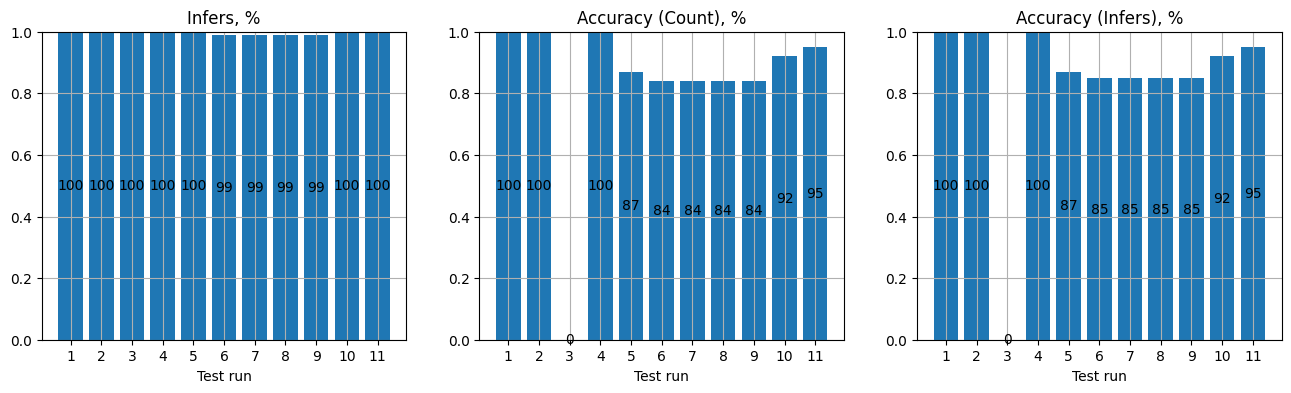

,config_variant,source_ds,cortical_columns,train_images_count,train_runs,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,,,,,,
1,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,1,1,1,1.00,1.00,1.000000
2,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,1,1,1,1.00,1.00,1.000000
3,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,1,1,0,1.00,0.00,0.000000
4,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,1,1,1,1.00,1.00,1.000000
5,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,100,100,87,1.00,0.87,0.870000
6,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,200,198,168,0.99,0.84,0.848485
7,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,200,198,168,0.99,0.84,0.848485
8,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,200,198,168,0.99,0.84,0.848485
9,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,200,198,168,0.99,0.84,0.848485


In [53]:
df_test_results2 = DF_TEST_RESULTS.copy()
df_test_results2['is_infer'] = df_test_results2['infer_value'] != ''
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'config_variant': 'first', 
                                                                     'source_ds': 'first',
                                                                     'cortical_columns': 'first',
                                                                     'train_images_count': 'first',
                                                                     'train_runs': 'first',
                                                                     'test_image_id': 'count', 
                                                                     'is_infer': 'sum', 
                                                                     'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']
df_test_results2['accuracy_infers'] = df_test_results2['accuracy_infers'].fillna(0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2

In [54]:
df_last_run_results = DF_TEST_RESULTS[DF_TEST_RESULTS.test_run_id == max(DF_TEST_RESULTS.test_run_id)]
df_incorrect = df_last_run_results.loc[df_last_run_results.true_value != df_last_run_results.infer_value]
df_incorrect

,test_run_id,config_variant,cortical_columns,train_images_count,train_runs,source_ds,test_image_id,true_value,infer_value,match_tab_index,match_score
1129,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100008106,7,1,25,294.156799
1185,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100000257,8,0,81,889.921692
1224,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100001440,4,8,120,446.201813
1237,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100001529,4,9,133,393.627350
1249,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100007388,5,3,145,512.188782
1252,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100001823,8,4,148,715.773499
1254,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100002454,6,0,150,669.098633
1262,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100008984,7,4,158,1133.187134
1280,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100000583,2,0,176,984.615417
1289,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100004048,0,7,185,368.627930


In [123]:
df_last_run_results = DF_TEST_RESULTS[DF_TEST_RESULTS.test_run_id == max(DF_TEST_RESULTS.test_run_id)]
df_correct = df_last_run_results.loc[df_last_run_results.true_value == df_last_run_results.infer_value]
# list(df_correct.match_tab_index)

In [74]:
df_last_run_results.loc[df_last_run_results.true_value == df_last_run_results.infer_value].match_score.describe()

count     190.000000
mean      589.994401
std       276.728774
min       114.231644
25%       411.731316
50%       541.339111
75%       724.504585
max      2093.085632
Name: match_score, dtype: float64

In [75]:
df_last_run_results.loc[(df_last_run_results.true_value != df_last_run_results.infer_value) & (np.isfinite(df_last_run_results.match_score))].match_score.describe()

count      10.000000
mean      640.739905
std       286.527159
min       294.156799
25%       406.770966
50%       590.643707
75%       846.384644
max      1133.187134
Name: match_score, dtype: float64

In [125]:
match_tabs[145]

,image_id,value,candidate_engram_id,candidate_image_id,candidate_value,match_mat,match_vector,match_score
166,100007388,5,199,40480,3,[[512.1887817382812]],[512.1887817382812],512.188782
1,100007388,5,2,33537,5,[[517.3086547851562]],[517.3086547851562],517.308655
102,100007388,5,119,28679,5,[[534.7312622070312]],[534.7312622070312],534.731262
65,100007388,5,76,5526,5,[[598.6135864257812]],[598.6135864257812],598.613586
134,100007388,5,156,32902,5,[[610.102783203125]],[610.102783203125],610.102783
...,...,...,...,...,...,...,...,...
171,100007388,5,204,22139,2,"[[924.259765625], [inf]]",[924.259765625],inf
169,100007388,5,202,47558,4,"[[890.302001953125], [inf]]",[890.302001953125],inf
160,100007388,5,193,31039,8,"[[950.9163818359375], [inf]]",[950.9163818359375],inf
162,100007388,5,195,52092,7,"[[1046.639892578125], [inf]]",[1046.639892578125],inf


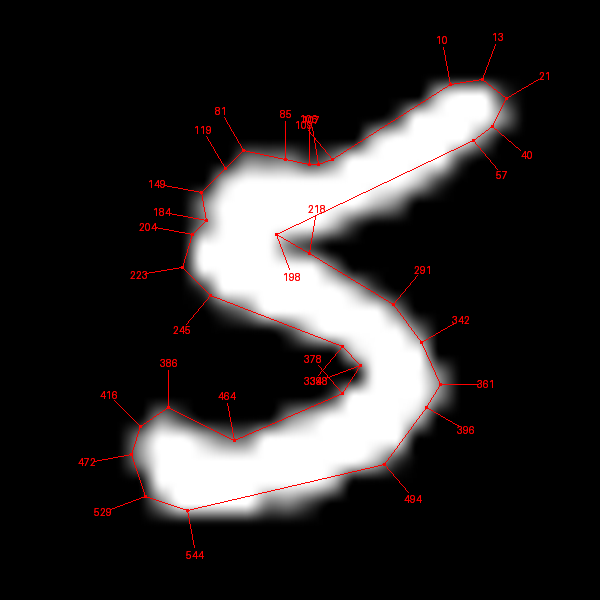

In [126]:
render_image(100007388, df_test_images, with_sequences=True)

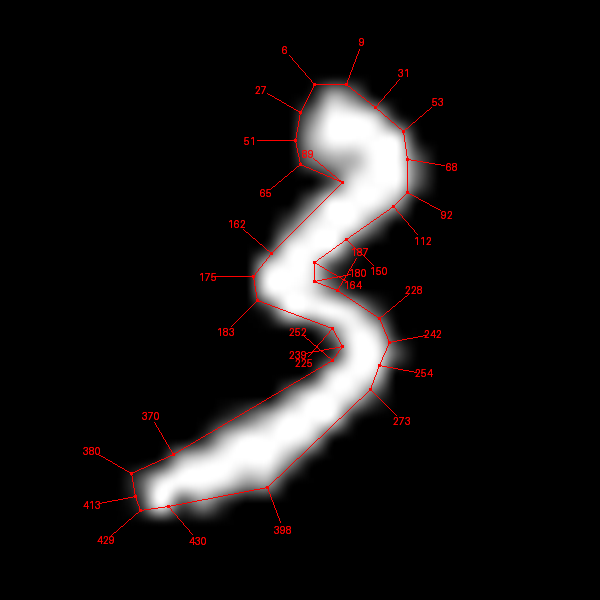

In [127]:
render_image(40480, df_train_images, with_sequences=True)

In [128]:
df_image = test_run_source[0].loc[100007388]
sensor_instance_ind_dict = pickle.loads(df_image['si'])
sequences_full = pickle.loads(df_image['seq'])
sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)
sensor_instance_ind_to_latent_vector = calc_si_latent_vectors(sequences, sensor_instance_ind_dict)
connection_vectors_list = calc_si_connection_vectors(sequences, sensor_instance_ind_dict)
seq_lvs = []

for seq, connection_vectors in zip(sequences, connection_vectors_list):
    seq_lv, si_ind_to_offset = calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict)
    seq_lvs.append((seq_lv, si_ind_to_offset))

engram_to_match_mat = {}

# Check every sequence of an image under study
for seq_index, seq in enumerate(sequences):
    # seq_lv, si_ind_to_offset = seq_lvs[seq_index]
    seq_lv, _ = seq_lvs[seq_index]
    seq_lv_phases = np.empty((seq_lv.shape[0], seq_lv.shape[0]), dtype='F')

    for i in range(seq_lv.shape[0]):
        seq_lv_phases[i] = seq_lv
        seq_lv = np.roll(seq_lv, +1)
    
    # Explore various hooks - one may be better than other due to different phases of rolled seq_lv
    si_inds = RNG.choice(seq, min(5, len(seq)), replace=False)

    for si_ind in si_inds:
        si_lv = sensor_instance_ind_to_latent_vector[si_ind]
        cos_sims = HOOK_LVS.array_active @ si_lv
        cos_sim_indices = np.argwhere(cos_sims > COS_SIM_45).ravel()
        
        for cos_sim_index in cos_sim_indices:
            candidate_seq_lv_box = SEQ_LV_DICT[cos_sim_index]
            candidate_engram = ENGRAM_DICT[candidate_seq_lv_box.engram_id]

            if candidate_engram.image_id != 40480:
                continue
        
            if not candidate_engram.engram_id in engram_to_match_mat:
                engram_to_match_mat[candidate_engram.engram_id] = np.full((candidate_engram.seqs_count, len(sequences)), np.inf)
                
            match_mat = engram_to_match_mat[candidate_engram.engram_id]
    
            if np.isfinite(match_mat[candidate_seq_lv_box.seq_index,seq_index]):
                # this relation (candidate_seq_lv_box.seq_index VS seq_index) is already assessed
                continue

            # print(candidate_seq_lv_box.seq_index, seq_index, candidate_seq_lv_box.lv[0])
            # Find best match between seq_lv and candidate_seq_lv_box.lv via thorough phasing
            seq_lv_diffs_mat = candidate_seq_lv_box.lv - seq_lv_phases
            seq_lv_diffs_mat = np.absolute(seq_lv_diffs_mat)
            seq_lv_diffs_vec = np.sum(seq_lv_diffs_mat, axis=1)
            match_mat[candidate_seq_lv_box.seq_index, seq_index] = np.min(seq_lv_diffs_vec)
            assert False

AssertionError: 

In [129]:
qqq = np.argmin(seq_lv_diffs_vec)

In [130]:
seq_lv_diffs_vec[qqq]

np.float32(505.31198)

In [131]:
np.absolute(candidate_seq_lv_box.lv - seq_lv_phases[qqq]).sum()

np.float32(505.31198)

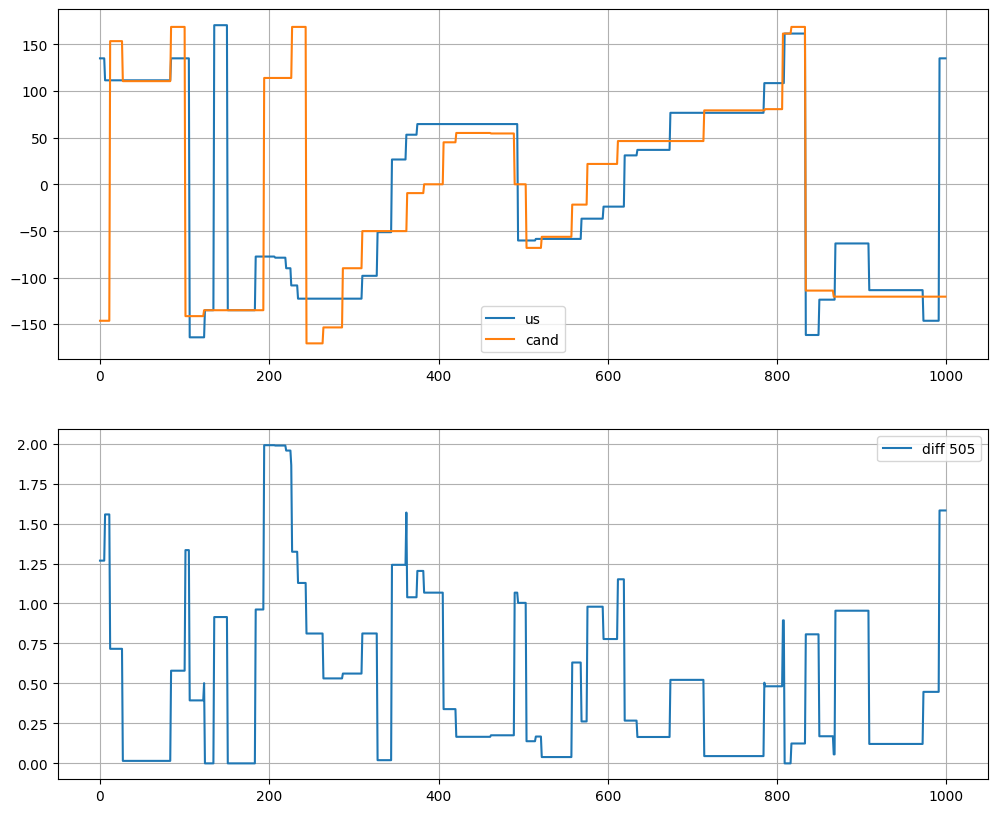

In [135]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.plot(np.angle(seq_lv_phases[qqq], deg=True), label=f'us')
plt.plot(np.angle(candidate_seq_lv_box.lv, deg=True), label=f'cand')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.absolute(candidate_seq_lv_box.lv - seq_lv_phases[qqq]), label=f'diff {np.sum(np.absolute(candidate_seq_lv_box.lv - seq_lv_phases[qqq])):.0f}')
plt.grid()
plt.legend()

plt.show()

In [138]:
np.absolute(candidate_seq_lv_box.lv[200] - seq_lv_phases[qqq][200])

np.float32(1.9900527)

In [142]:
candidate_seq_lv_box.lv[200], seq_lv_phases[qqq][200], np.angle(candidate_seq_lv_box.lv[200], deg=True), np.angle(seq_lv_phases[qqq][200], deg=True)

(np.complex64(-0.40613848+0.91381156j),
 np.complex64(0.21693046-0.97618705j),
 np.float32(113.96249),
 np.float32(-77.47119))

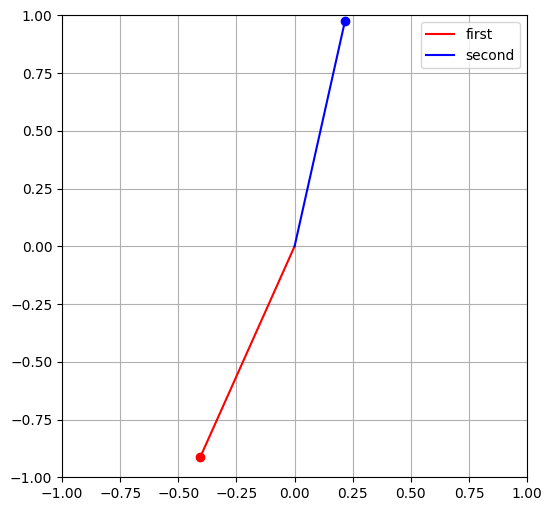

In [141]:
vec1 = [-0.40613848, +0.91381156,  0.21693046, -0.97618705]

plt.figure(figsize=(6, 6))
plt.plot([0, vec1[0]], [0, -vec1[1]], 'r', label='first')
plt.scatter(vec1[0], -vec1[1], c='r')
plt.plot([0, vec1[2]], [0, -vec1[3]], 'b', label='second')
plt.scatter(vec1[2], -vec1[3], c='b')
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.legend()
plt.grid()
plt.show()